In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [202]:
file_path = "house_price.csv"

df = pd.read_csv(file_path, index_col=0)
df.reset_index(inplace=True)

In [203]:
df = df.drop(columns=['Address', 'HouseType', 'PostalCode', 'Parking', 'SoldDate'])

## Fill N/A
df["FloodPlain"] = df["FloodPlain"].fillna("No")
df["View"] = df["View"].fillna("No")
df["DepthSizeFt"] = df["DepthSizeFt"].ffill().bfill()
df["Suite"] = df["Suite"].fillna("No")
df["Basement"] = df["Basement"].fillna("No")

## Convert Values into Booleans
df.loc[df["Suite"].str.contains("Suite"), 'Suite'] = "Yes"
df.loc[df["Suite"].str.contains("Other"), 'Suite'] = "No"
df.loc[df["Basement"].str.contains("Full"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Crawl"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Separate"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Finished"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Part"), 'Basement'] = "Yes"

df

,SalePrice,Bedrooms,Bathrooms,YearBuilt,Age,LotAreaSqft,FloodPlain,View,FrontageFt,DepthSizeFt,FinishedFloorTotalSqft,Suite,Basement,NumberOfLevels,NumberOfRooms,PrimeRate
0,"$950,000",4,2,1957,63,"4,560.00",No,No,40.00,114.00,"2,216",No,Yes,2,8,0.0245
1,"$1,000,000",5,3,1948,71,"6,100.00",No,No,50.00,122.00,"2,630",Yes,Yes,3,11,0.0395
2,"$1,120,000",2,1,1952,68,"4,982.00",No,No,47.00,106.00,700,No,No,1,4,0.0245
3,"$1,160,000",5,2,1949,71,"6,600.00",No,No,55.00,120.00,"2,096",Yes,No,2,17,0.0245
4,"$1,200,000",5,3,1981,39,0,No,Yes,47.00,106.00,"3,522",Yes,No,2,16,0.0245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,"$2,570,000",7,6,2012,12,"6,000.00",No,No,50.00,120.00,"3,566",Yes,Yes,3,15,0.0720
102,"$2,690,000",6,5,2014,8,"6,360.00",No,No,53.00,120.00,"3,103",Yes,No,2,16,0.0245
103,"$2,910,000",6,5,2017,6,"6,533.00",No,No,68.52,95.01,"3,865",Yes,Yes,3,17,0.0720
104,"$2,998,800",6,5,2017,5,"5,550.00",No,No,50.00,111.00,"3,350",Yes,Yes,3,15,0.0270


In [204]:
## Feature engineering (add 2 new ratio)
df["BathroomToRoomRatio"] = round(df["Bathrooms"] / df["NumberOfRooms"], 2)
df["BedroomToRoomRatio"] = round(df["Bedrooms"] / df["NumberOfRooms"], 2)

In [205]:
df.isnull().sum()


SalePrice                 0
Bedrooms                  0
Bathrooms                 0
YearBuilt                 0
Age                       0
LotAreaSqft               0
FloodPlain                0
View                      0
FrontageFt                0
DepthSizeFt               0
FinishedFloorTotalSqft    0
Suite                     0
Basement                  0
NumberOfLevels            0
NumberOfRooms             0
PrimeRate                 0
BathroomToRoomRatio       0
BedroomToRoomRatio        0
dtype: int64

In [206]:
## Convert SalePrice to float
df["SalePrice"] = df["SalePrice"].str.replace("$", "")
df["SalePrice"] = df["SalePrice"].str.replace(",", "").astype(float)

## Convert LotAreaSqft to float
df["LotAreaSqft"] = df["LotAreaSqft"].str.replace(",", "").astype(float)
df["FinishedFloorTotalSqft"] = df["FinishedFloorTotalSqft"].str.replace(",", "").astype(float)

In [207]:
df

,SalePrice,Bedrooms,Bathrooms,YearBuilt,Age,LotAreaSqft,FloodPlain,View,FrontageFt,DepthSizeFt,FinishedFloorTotalSqft,Suite,Basement,NumberOfLevels,NumberOfRooms,PrimeRate,BathroomToRoomRatio,BedroomToRoomRatio
0,950000.0,4,2,1957,63,4560.0,No,No,40.00,114.00,2216.0,No,Yes,2,8,0.0245,0.25,0.50
1,1000000.0,5,3,1948,71,6100.0,No,No,50.00,122.00,2630.0,Yes,Yes,3,11,0.0395,0.27,0.45
2,1120000.0,2,1,1952,68,4982.0,No,No,47.00,106.00,700.0,No,No,1,4,0.0245,0.25,0.50
3,1160000.0,5,2,1949,71,6600.0,No,No,55.00,120.00,2096.0,Yes,No,2,17,0.0245,0.12,0.29
4,1200000.0,5,3,1981,39,0.0,No,Yes,47.00,106.00,3522.0,Yes,No,2,16,0.0245,0.19,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2570000.0,7,6,2012,12,6000.0,No,No,50.00,120.00,3566.0,Yes,Yes,3,15,0.0720,0.40,0.47
102,2690000.0,6,5,2014,8,6360.0,No,No,53.00,120.00,3103.0,Yes,No,2,16,0.0245,0.31,0.38
103,2910000.0,6,5,2017,6,6533.0,No,No,68.52,95.01,3865.0,Yes,Yes,3,17,0.0720,0.29,0.35
104,2998800.0,6,5,2017,5,5550.0,No,No,50.00,111.00,3350.0,Yes,Yes,3,15,0.0270,0.33,0.40


In [208]:
## Encode Categorical Values into Numeric Values
encoder = LabelEncoder()
df["FloodPlain"] = encoder.fit_transform(df["FloodPlain"])
df["View"] = encoder.fit_transform(df["View"])
df["Suite"] = encoder.fit_transform(df["Suite"])
df["Basement"] = encoder.fit_transform(df["Basement"])

In [209]:
df

,SalePrice,Bedrooms,Bathrooms,YearBuilt,Age,LotAreaSqft,FloodPlain,View,FrontageFt,DepthSizeFt,FinishedFloorTotalSqft,Suite,Basement,NumberOfLevels,NumberOfRooms,PrimeRate,BathroomToRoomRatio,BedroomToRoomRatio
0,950000.0,4,2,1957,63,4560.0,0,0,40.00,114.00,2216.0,0,1,2,8,0.0245,0.25,0.50
1,1000000.0,5,3,1948,71,6100.0,0,0,50.00,122.00,2630.0,1,1,3,11,0.0395,0.27,0.45
2,1120000.0,2,1,1952,68,4982.0,0,0,47.00,106.00,700.0,0,0,1,4,0.0245,0.25,0.50
3,1160000.0,5,2,1949,71,6600.0,0,0,55.00,120.00,2096.0,1,0,2,17,0.0245,0.12,0.29
4,1200000.0,5,3,1981,39,0.0,0,1,47.00,106.00,3522.0,1,0,2,16,0.0245,0.19,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2570000.0,7,6,2012,12,6000.0,0,0,50.00,120.00,3566.0,1,1,3,15,0.0720,0.40,0.47
102,2690000.0,6,5,2014,8,6360.0,0,0,53.00,120.00,3103.0,1,0,2,16,0.0245,0.31,0.38
103,2910000.0,6,5,2017,6,6533.0,0,0,68.52,95.01,3865.0,1,1,3,17,0.0720,0.29,0.35
104,2998800.0,6,5,2017,5,5550.0,0,0,50.00,111.00,3350.0,1,1,3,15,0.0270,0.33,0.40


In [210]:
type(df)

pandas.core.frame.DataFrame

<Axes: >

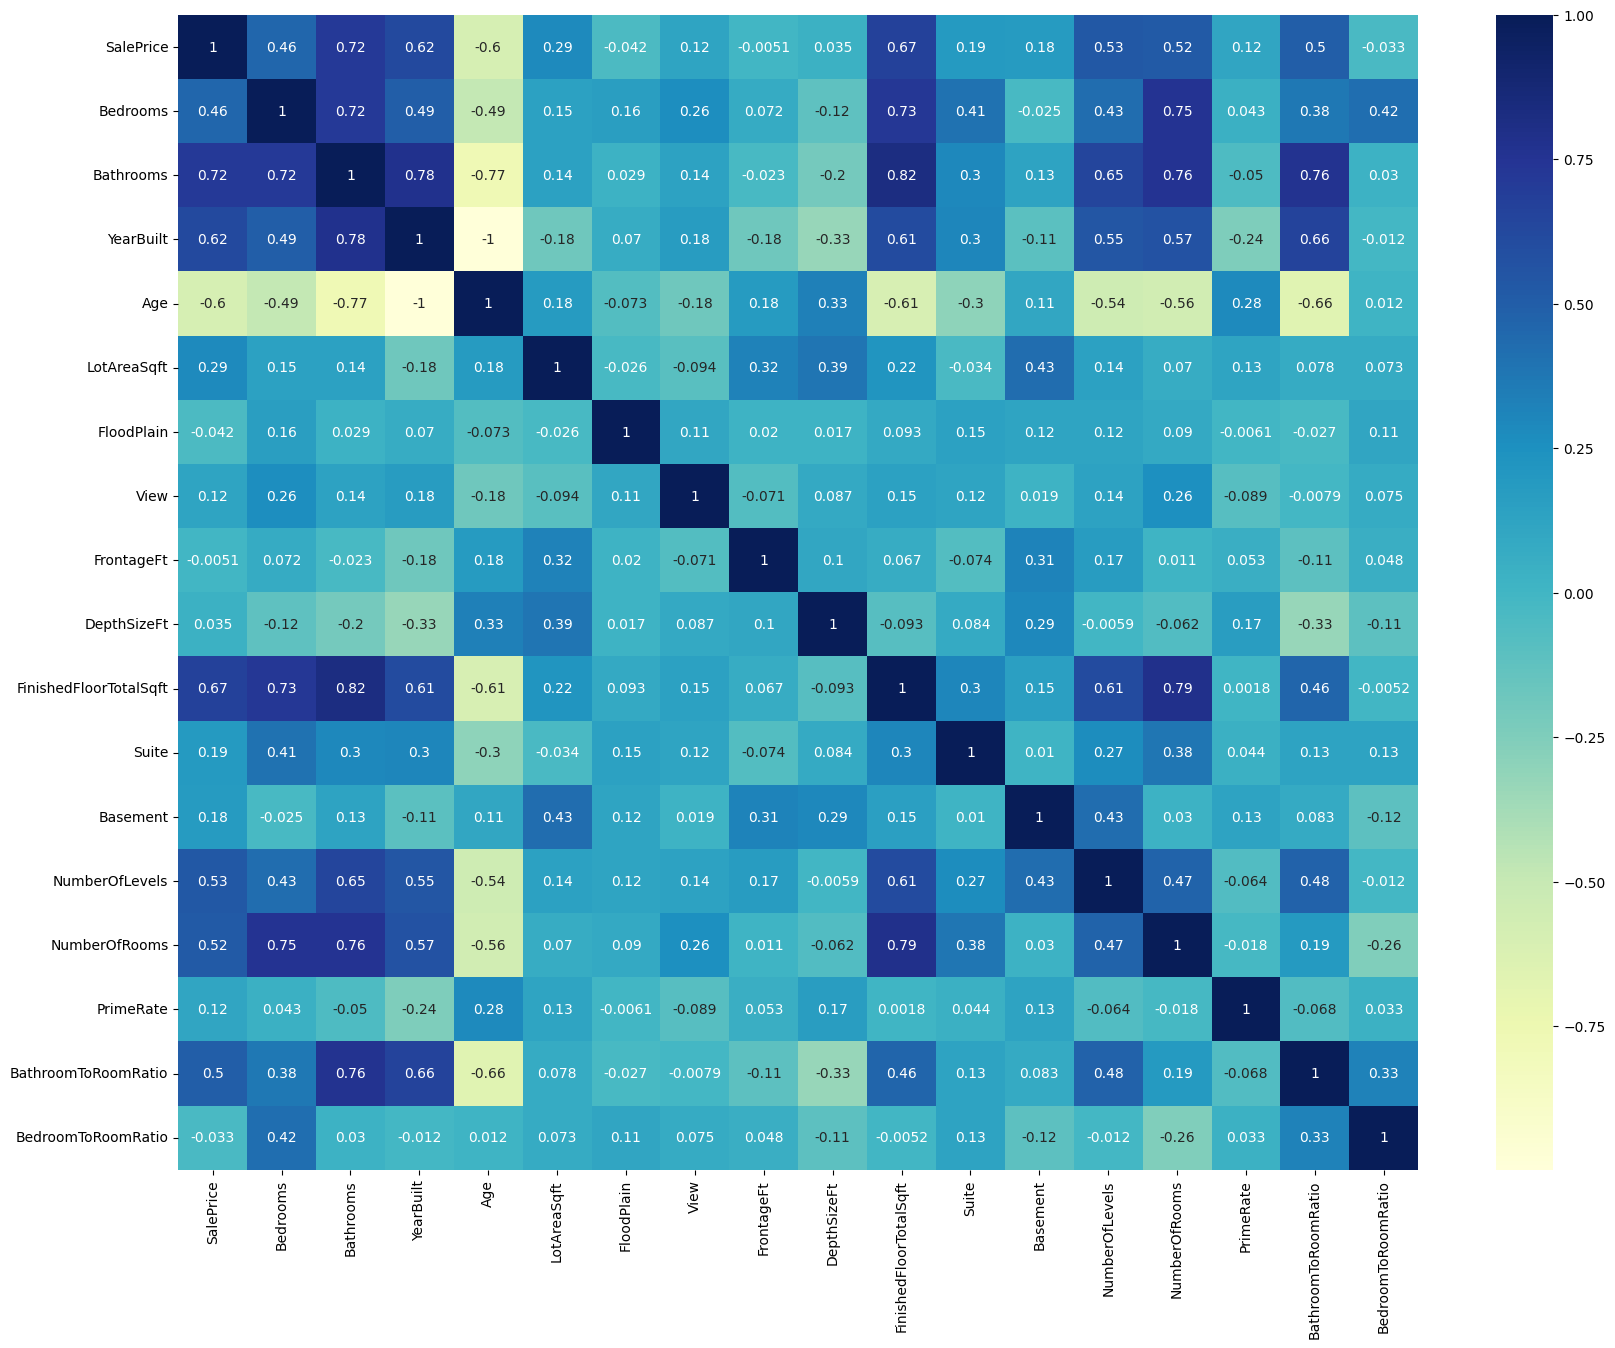

In [211]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

## All Features

In [212]:
def all_features_model():
    ## Features
    X = df.drop(["SalePrice"], axis=1)

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

## Bathrooms

In [213]:
def bathrooms_model():
    ## Features
    X = df["Bathrooms"]

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

## YearBuilt

In [214]:
def yearbuilt_model():
    ## Features
    X = df["YearBuilt"]

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

## FinishedFloorTotalSqft

In [215]:
def sqft_model():
    ## Features
    X = df["FinishedFloorTotalSqft"]

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

## Number of Levels

In [216]:
def levels_model():
    ## Features
    X = df["NumberOfLevels"]

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

## Number of Rooms

In [217]:
def rooms_model():
    ## Features
    X = df["NumberOfRooms"]

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

## BathroomToRoomRatio

In [218]:
def ratio_model():
    ## Features
    X = df["BathroomToRoomRatio"]

    ## Target Variable
    y = df["SalePrice"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    ## Split Train set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=64)

    ## Initiate Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    ## Make Prediction
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to original SalePrice scale
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred)

    ## Performance Scores
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'RMSE: {rmse}')

In [219]:
# Example data for a single house
new_house = {
    'Bathrooms': [2],
    'Bedrooms': [3],
    'NumberOfRooms': [7],
    'NumberOfLevels': [2],
    'YearBuilt': [1975],
    'Age': [45],
    'LotAreaSqft': [5000],
    'FinishedFloorTotalSqft': [2000],
    'FloodPlain': [0],
    'View': [1],
    'Suite': [1],
    'Basement': [1],
    'FrontageFt': [50.0],
    'DepthSizeFt': [114.0],
    'PrimeRate': [0.01]
}

new_house['BathroomToRoomRatio'] = [round(new_house['Bathrooms'][0] / new_house['NumberOfRooms'][0], 1)]
new_house['BedroomToRoomRatio'] = [round(new_house['Bedrooms'][0] / new_house['NumberOfRooms'][0], 1)]

def price_prediction(data, future_years=5):
    # Define features (X) and target (y)
    X = df.drop(columns=['SalePrice'], axis=1)  # Features
    y = df['SalePrice']  # Target variable

    # Convert the input data to a DataFrame
    house_data = pd.DataFrame(data)

    # Ensure the columns are in the same order as the training data (X.columns)
    house_data = house_data[X.columns]

    # Initialize scalers for X and y
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Scale the training data
    X_scaled = scaler_X.fit_transform(X)  # Fit and transform X
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Fit and transform y

    # Cross-validation using KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LinearRegression()
    cv_scores = cross_val_score(model, X_scaled, y_scaled.ravel(), cv=kf, scoring='r2')

    print(f"Cross-Validation R² Scores: {cv_scores}")
    print(f"Mean R² Score: {np.mean(cv_scores)}")

    # Split the training data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    predicted_prices = []
    current_house_data = house_data.copy()

    for _ in range(future_years):
        current_house_data_scaled = scaler_X.transform(current_house_data)
        y_pred_scaled = model.predict(current_house_data_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0][0]
        predicted_prices.append(y_pred)
        current_house_data['Age'] = current_house_data['Age'] + 1

        current_house_data['SalePrice'] = y_pred

        current_house_data_scaled = scaler_X.transform(current_house_data.drop(columns=['SalePrice']))
        current_house_data = pd.DataFrame(scaler_X.inverse_transform(current_house_data_scaled), columns = X.columns)
    
    future_years_list = [2024 + i for i in range(future_years)]

    plt.figure(figsize=(10, 6))
    plt.plot(future_years_list, predicted_prices, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Predicted Price')
    plt.title('Future Predicted House Price')
    plt.xticks(future_years_list)
    plt.grid(True)
    plt.show()

    float_prices = [float(price) for price in predicted_prices]

    # Convert to regular Python floats
    for i, year in enumerate(future_years_list):
        print(f"Year {year}")
        print(f"Price: {float_prices[i]}\n")




Cross-Validation R² Scores: [0.76956032 0.62234369 0.71067982 0.75729863 0.72735838]
Mean R² Score: 0.7174481693975452


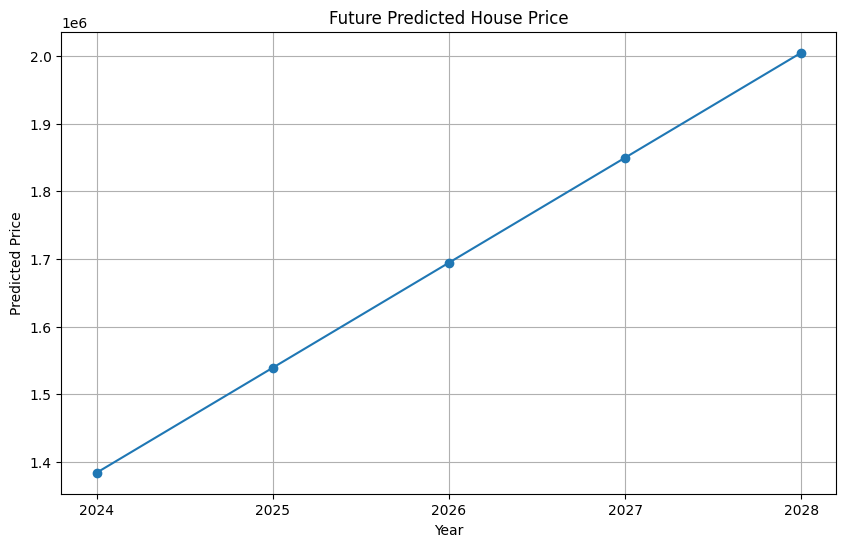

Year 2024
Price: 1384127.5144642591

Year 2025
Price: 1539276.2359788262

Year 2026
Price: 1694424.9574933932

Year 2027
Price: 1849573.6790079603

Year 2028
Price: 2004722.400522527



In [220]:
price_prediction(new_house)